# Part 2 - Sentiment Analysis

#### 01 - Load Data

In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
df = pd.read_csv("./data/tweets.csv")
df.head(5)

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Tushar Gupta at DevFest Raipur.,Is this the end of Twitter threads?\n#AI #Chat...,India,•Experiencing Life💬 && Tech🥑 •Learning about💻:...,2021-10-05 05:05:55+00:00,230.0,438.0,1567,False,2022-12-20 13:29:08+00:00,"['AI', 'ChatGPT']",Twitter for Android
1,PharmaTechnologyTrends,ChatGPT is a truly mind-blowing tool and playi...,"Frankfurt am Main, Deutschland",Latest News and Trends in Pharmaceutical Industry,2022-11-06 21:03:59+00:00,264.0,4333.0,24,False,2022-12-20 13:28:50+00:00,NaN,EveryoneSocial
2,Richard Kim,#ChatGPT can be used to generate malicious cod...,NaN,"News, papers, and books on AI, Machine Learnin...",2010-05-06 00:20:48+00:00,4481.0,4982.0,18412,False,2022-12-20 13:28:39+00:00,"['ChatGPT', 'code', 'chatgpt', 'language', 'ai...",shem0304
3,GiamMa-based researchers SDR R&D IoT,Use prompt hack to bypass OpenAI's content pol...,NaN,#ArtTechnology #IT #Hardware #Security #OSINT ...,2020-08-29 09:30:40+00:00,1996.0,1190.0,19528,False,2022-12-20 13:28:09+00:00,NaN,Twitter Web App
4,"Bobby Davis, Jr.",Why #chatgpt will never replace devs. \n\nhttp...,North Carolina,CEO @CoderFoundry\nAuthor: Breaking the Code h...,2012-06-25 17:36:19+00:00,1182.0,245.0,888,False,2022-12-20 13:27:10+00:00,['chatgpt'],Twitter for Android


#### 02 - NLP Cleaning

By observing the result in clustering, we found there are some spam messages, and all of them contains words "MidJour" or "Giveaway". After removing those rows, there are 400+ rows reduced.

The cleaning function above involves various common techniques in text preprocessing in NLP. Below is a detailed explanation of these steps:
- Use `Rege`x to remove URLs ensures irrelevant information has been excluded since URLs do not contain sentiment information that is useful for this research.
- Use `word_tokenize` to tokenize texts into individual tokens.
- Use lowercase, remove punctuation, remove stop words from `stopwords`, and stemming from `PorterStemmer` to ensure tokenized text free from redundancy, and standardize words to their root form.

In [3]:
# identify spam
df['is_spam'] = df['text'].apply(lambda x: 'spam' if 'MidJour' in x or 'Giveaway' in x else 'not_spam')
# spam tweets count
len(df[df['is_spam']=='spam'])

422

In [4]:
def preprocessing(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = []
    for token in word_tokenize(text):
        token = token.lower()
        if token not in stop_words and token.isalnum():
            cleaned_tokens.append(ps.stem(token))
            
    return ' '.join(cleaned_tokens)
df["preprocessed_text"] = df.text.apply(preprocessing)
df.head(5)

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source,is_spam,preprocessed_text
0,Tushar Gupta at DevFest Raipur.,Is this the end of Twitter threads?\n#AI #Chat...,India,•Experiencing Life💬 && Tech🥑 •Learning about💻:...,2021-10-05 05:05:55+00:00,230.0,438.0,1567,False,2022-12-20 13:29:08+00:00,"['AI', 'ChatGPT']",Twitter for Android,not_spam,end twitter thread ai chatgpt openai
1,PharmaTechnologyTrends,ChatGPT is a truly mind-blowing tool and playi...,"Frankfurt am Main, Deutschland",Latest News and Trends in Pharmaceutical Industry,2022-11-06 21:03:59+00:00,264.0,4333.0,24,False,2022-12-20 13:28:50+00:00,NaN,EveryoneSocial,not_spam,chatgpt truli tool play around definit send ra...
2,Richard Kim,#ChatGPT can be used to generate malicious cod...,NaN,"News, papers, and books on AI, Machine Learnin...",2010-05-06 00:20:48+00:00,4481.0,4982.0,18412,False,2022-12-20 13:28:39+00:00,"['ChatGPT', 'code', 'chatgpt', 'language', 'ai...",shem0304,not_spam,chatgpt use gener malici code find research co...
3,GiamMa-based researchers SDR R&D IoT,Use prompt hack to bypass OpenAI's content pol...,NaN,#ArtTechnology #IT #Hardware #Security #OSINT ...,2020-08-29 09:30:40+00:00,1996.0,1190.0,19528,False,2022-12-20 13:28:09+00:00,NaN,Twitter Web App,not_spam,use prompt hack bypass openai content polici r...
4,"Bobby Davis, Jr.",Why #chatgpt will never replace devs. \n\nhttp...,North Carolina,CEO @CoderFoundry\nAuthor: Breaking the Code h...,2012-06-25 17:36:19+00:00,1182.0,245.0,888,False,2022-12-20 13:27:10+00:00,['chatgpt'],Twitter for Android,not_spam,chatgpt never replac dev


#### 03 - Sentiment Analysis with `VADER`

Reference for VADER introduction: 
<br>
https://github.com/cjhutto/vaderSentiment
<br>
<br>
This section used `SentimentIntensityAnalyzer` from `VADER` to determine the sentiment of user review text. In specific, it examines the compound score (> 0.05: positive, < -0.05: negative, in-between: neutral) to set thresholds in categorizing sentiment labels as 1, -1, 0 respectively.
<br>
<br>
In this research, we conducted a series of sentiment analysis based on the user review from social media. This is align with the nature of `VADER`: "a rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media." (vaderSentiment). In addition, the choice of categorizing sentiment based on 0.05 and -0.05 compund score is a commonly used practice in sentiment analysis.
<br>
<br>
The limitation for this method is the value of thresholds in categorizing sentiment may not be an universal golden rule, hence adjust these thresholds accordingly with dataset might be necessary. Furthermore, using only 1, -1, and 0 for positive, negative, and neutral may leave out more detailed information about sentiments.

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

# Reference for categorizing compound score:
# https://towardsdatascience.com/social-media-sentiment-analysis-in-python-with-vader-no-training-required-4bc6a21e87b8

vader = SentimentIntensityAnalyzer()
def get_sentiment_labels(preprocessed_text):
    scores = vader.polarity_scores(preprocessed_text)
    compound = scores["compound"]
    
    # 1: positive
    # -1: negative
    # 0: neutral
    if compound > 0.05:
        return 1
    elif compound < -0.05:
        return -1
    else:
        return 0

df["label_vader"] = df.preprocessed_text.apply(get_sentiment_labels)

Text(0.5, 1.0, 'Distribution of Sentiment Labels (VADER)')

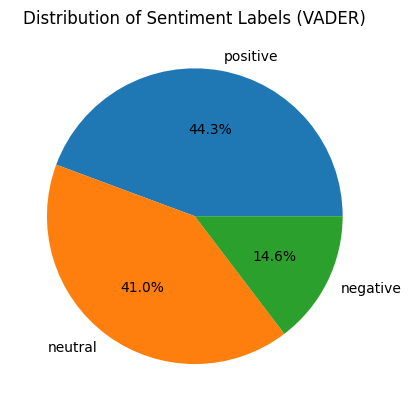

In [6]:
import matplotlib.pyplot as plt

label_value_counts = df.label_vader.value_counts()

plt.pie(label_value_counts, 
        labels = label_value_counts.index.map({1: 'positive', 0: 'neutral', -1: 'negative'}), 
        autopct= "%1.1f%%")

plt.title('Distribution of Sentiment Labels (VADER)')

#### 04 - Sentiment Analysis with `TextBlob`

Reference: https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis

The TextBlob sentiment analysis returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

We can define:
- polarity > 0.1 -> positive
- polarity < -0.1 -> negative
- -0.1 <= polarity <= 0.1 -> neutral

In [7]:
from textblob import TextBlob

def get_sentiment_labels_textblob(text):

    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    if polarity > 0.05:
        return 1  # pos
    elif polarity < -0.05:
        return -1  # neg
    else:
        return 0  # neu
        
df["label_textblob"] = df.preprocessed_text.apply(get_sentiment_labels_textblob)

Text(0.5, 1.0, 'Distribution of Sentiment Labels (TextBlob)')

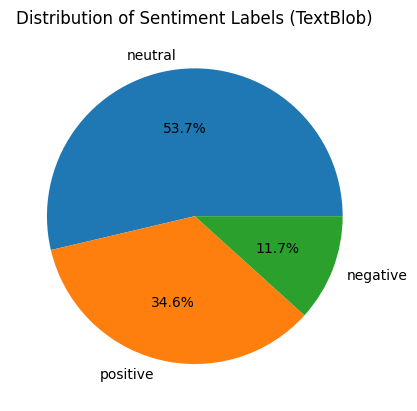

In [8]:
import matplotlib.pyplot as plt

label_value_counts = df.label_textblob.value_counts()

plt.pie(label_value_counts, 
        labels = label_value_counts.index.map({1: 'positive', 0: 'neutral', -1: 'negative'}), 
        autopct= "%1.1f%%")

plt.title('Distribution of Sentiment Labels (TextBlob)')

#### 05 - Sentiment Analysis with `Pre-trained BERT`
- Reference: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
This is a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark.

In [20]:
model_sa = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")
def get_sentiment_labels_roberta(model_sa, text):
    try:
        result = model_sa(text)[0]['label']
        dict_map = {"positive":1,
                    "neutral":0,
                    "negative":-1}
        return dict_map[result]
    except Exception as e:
        print(f"Error: {e}")
        return 0

label_bert_list = []
for i in range(len(df['text'])):
    current_sentiment_label = get_sentiment_labels_roberta(model_sa, df['text'][i])
    label_bert_list.append(current_sentiment_label)
    print("Current item:", str(i),"| Sentiment:", current_sentiment_label)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Current item: 0 | Sentiment: 0
Current item: 1 | Sentiment: 1
Current item: 2 | Sentiment: -1
Current item: 3 | Sentiment: 0
Current item: 4 | Sentiment: 0
Current item: 5 | Sentiment: 0
Current item: 6 | Sentiment: 1
Current item: 7 | Sentiment: 1
Current item: 8 | Sentiment: 1
Current item: 9 | Sentiment: 0
Current item: 10 | Sentiment: 1
Current item: 11 | Sentiment: -1
Current item: 12 | Sentiment: 0
Current item: 13 | Sentiment: 1
Current item: 14 | Sentiment: 0
Current item: 15 | Sentiment: 1
Current item: 16 | Sentiment: 1
Current item: 17 | Sentiment: 1
Current item: 18 | Sentiment: 1
Current item: 19 | Sentiment: 0
Current item: 20 | Sentiment: 0
Current item: 21 | Sentiment: 1
Current item: 22 | Sentiment: 0
Current item: 23 | Sentiment: -1
Current item: 24 | Sentiment: 1
Current item: 25 | Sentiment: 1
Current item: 26 | Sentiment: 0
Current item: 27 | Sentiment: 1
Current item: 28 | Sentiment: 0
Current item: 29 | Sentiment: 1
Current item: 30 | Sentiment: 1
Current item: 3

In [21]:
df["label_roberta"] = label_bert_list

Text(0.5, 1.0, 'Distribution of Sentiment Labels (twitter-roberta)')

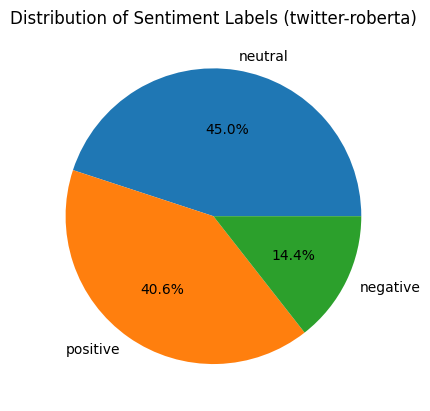

In [24]:
label_value_counts = df.label_roberta.value_counts()

plt.pie(label_value_counts, 
        labels = label_value_counts.index.map({1: 'positive', 0: 'neutral', -1: 'negative'}), 
        autopct= "%1.1f%%")

plt.title('Distribution of Sentiment Labels (twitter-roberta)')

In [26]:
# save the dataset for the following computation
df.to_csv("./data/tweets_with_sentiment_label.csv",index=None)

#### 06 - Evaluate on a small sample set
- Randomly select 100 tweets and create a test set with human-generated labels.
- Evaluate the models' predictions on this test set. Results show that the **Roberta** model performs the best. This will be the basis for further analysis.

In [28]:
not_spam = df[df['is_spam'] == 'not_spam']
sampled = not_spam.sample(n=100)

# can load "sampled_100_tweets_with_human_label.csv" to repeat the results

In [40]:
for i in range(10):
    print("TWEET",i,"to",(i+1)*10)
    for j in range(10):
        print(i*10+j, list(sampled['text'])[i*10+j])

TWEET 0 to 10
0 Chatgpt is giving nostalgia to the gen-x to the the time when google was launched and gen-z can’t just get over it😂

#ChatGPT #elonmusk #Revolution
1 This AI #chatbot is dominating #socialmedia with its frighteningly good essays  https://t.co/s9DwwQsbjy #OpenAI #ChatGPT #MachineLearning #DeepLearning #ArtificialIntelligence
2 Dec "4"...Truth brings reconciliation 😉
#Dictionary #ChatGPT 
@elonmusk https://t.co/H8L73L4U8f
3 Here is an article about the Future of #NFTs w #chatgpt

It smells like #WEB4

https://t.co/u5aTNeZu70
4 It's the end of the year review season at work. Multiple times today I've seen #ChatGPT be unavailable due to high load... I don't think this is a coincidence.
5 Full stack cavemen CV chatGPT via /r/weirdGPT #chatGPT https://t.co/Ylx3IT70pA
6 Me: What do you think Holden would like the world to be?

chatGPT: Overall, it is likely that Holden would want the world to be a kinder and more genuine place, where people are able to be themselves and suppor

In [60]:
# These human labels were determined by multiple external people and examined by inter rater agreement methods of Fleiss' Kappa.
human_label = [
    1,1,0,0,0,
    0,1,1,-1,0,
    1,1,1,0,0,
    -1,0,1,1,1,
    0,-1,0,1,0,
    0,-1,0,0,-1,
    1,0,0,-1,0,
    1,1,1,0,0,
    1,0,0,-1,1,
    1,1,0,0,0,
    0,1,0,0,0,
    0,0,1,0,1,
    1,0,0,0,0,
    -1,0,0,0,0,
    1,0,0,-1,0,
    1,1,-1,1,1,
    0,0,0,0,-1,
    1,0,1,-1,0,
    1,1,0,0,0,
    0,0,0,1,-1]

In [44]:
sampled["label_human"]=human_label
sampled.to_csv("./data/sampled_100_tweets_with_human_label.csv",index=None)

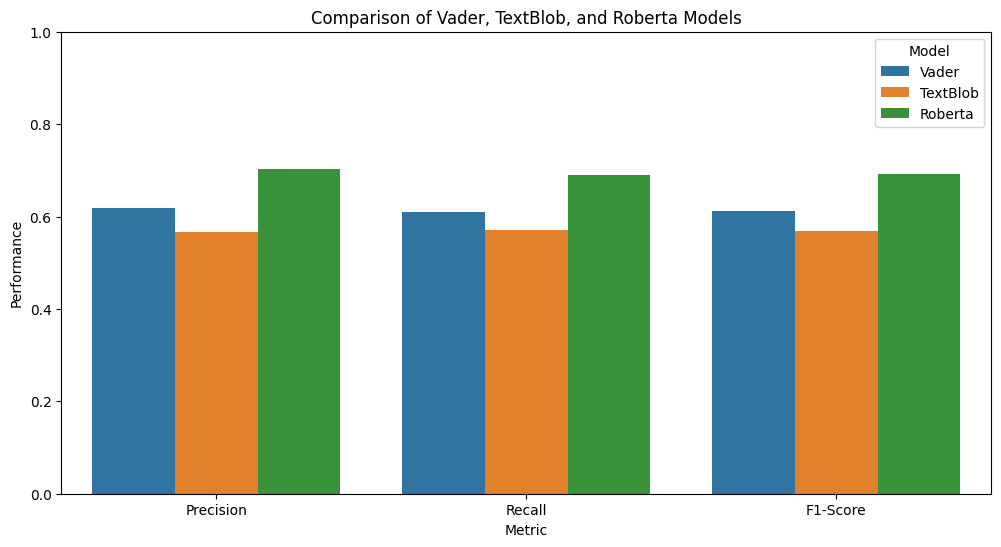

In [59]:
labels = ['label_vader', 'label_textblob', 'label_roberta', 'label_human']
data = sampled[labels]

accuracy_vader = accuracy_score(data['label_human'], data['label_vader'])
precision_vader = precision_score(data['label_human'], data['label_vader'], average='weighted')
recall_vader = recall_score(data['label_human'], data['label_vader'], average='weighted')
f1_vader = f1_score(data['label_human'], data['label_vader'], average='weighted')

accuracy_textblob = accuracy_score(data['label_human'], data['label_textblob'])
precision_textblob = precision_score(data['label_human'], data['label_textblob'], average='weighted')
recall_textblob = recall_score(data['label_human'], data['label_textblob'], average='weighted')
f1_textblob = f1_score(data['label_human'], data['label_textblob'], average='weighted')

accuracy_roberta = accuracy_score(data['label_human'], data['label_roberta'])
precision_roberta = precision_score(data['label_human'], data['label_roberta'], average='weighted')
recall_roberta = recall_score(data['label_human'], data['label_roberta'], average='weighted')
f1_roberta = f1_score(data['label_human'], data['label_roberta'], average='weighted')

metrics = pd.DataFrame({
    'Model': ['Vader', 'TextBlob', 'Roberta'],
    'Precision': [precision_vader, precision_textblob, precision_roberta],
    'Recall': [recall_vader, recall_textblob, recall_roberta],
    'F1-Score': [f1_vader, f1_textblob, f1_roberta]
})

metrics_melted = pd.melt(metrics, id_vars='Model', var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_melted)
plt.title('Comparison of Vader, TextBlob, and Roberta Models')
plt.ylabel('Performance')
plt.ylim(0, 1)
plt.show()

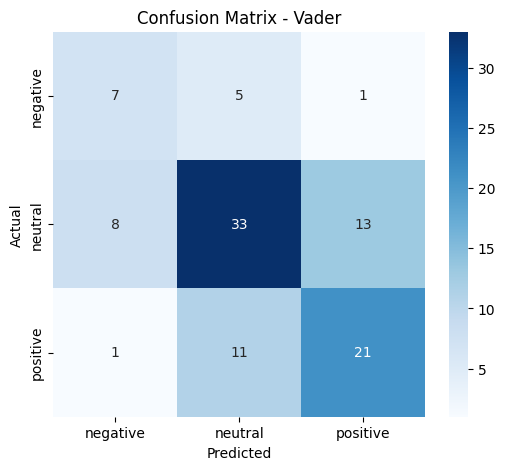

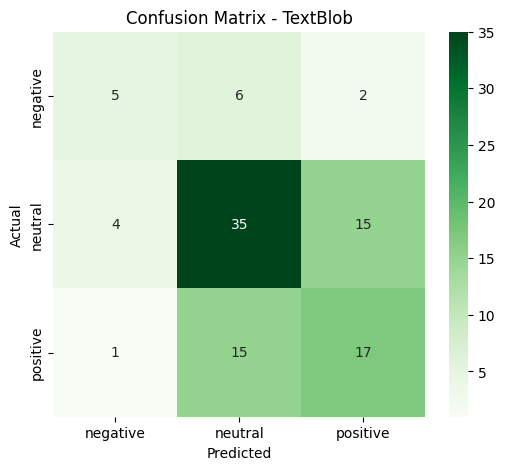

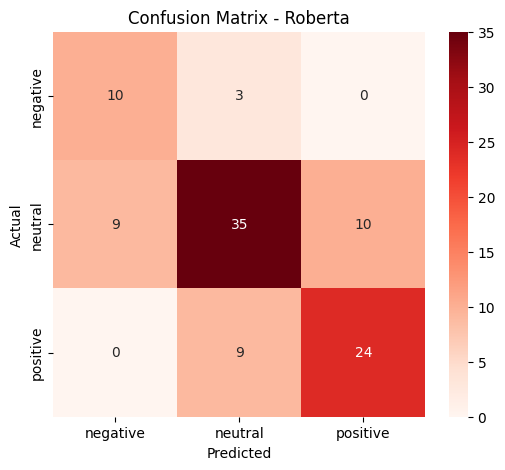

In [56]:
# confusion matrix
cm_vader = confusion_matrix(data['label_human'], data['label_vader'])
cm_textblob = confusion_matrix(data['label_human'], data['label_textblob'])
cm_roberta = confusion_matrix(data['label_human'], data['label_roberta'])

label_names_correct_order = ['negative', 'neutral', 'positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Blues', xticklabels=label_names_correct_order, yticklabels=label_names_correct_order)
plt.title('Confusion Matrix - Vader')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_textblob, annot=True, fmt='d', cmap='Greens', xticklabels=label_names_correct_order, yticklabels=label_names_correct_order)
plt.title('Confusion Matrix - TextBlob')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Reds', xticklabels=label_names_correct_order, yticklabels=label_names_correct_order)
plt.title('Confusion Matrix - Roberta')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()